# QBS 108 2023 Spring Project 3

## Question 1 Feed-forward Neural Network for Binary Classification 
You are given a real-world dataset to predict the prognosis of Breast Cancer patients using genetic biomarkers. Your task is to predict the breast cancer prognostic status, whose variable name is "outcome". A value of 1 is worse prognosis and a value of 0 is better prognosis. The codebook of this dataset is provided in hw3\_codebook.xlsx. 

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

dt_dev = pd.read_csv('/content/drive/MyDrive/QBS/BRCA-prognosis-train.csv')
all_columns = dt_dev.columns.tolist()
mutation_columns = all_columns[489:-1] #Gene mutation
expression_columns = all_columns[:489]  #Gene expression

# fix missing data
for var in mutation_columns:
    dt_dev.loc[:,var] = dt_dev[var].apply(lambda x: 0 if x == '0' else 1)
    
for var in dt_dev.columns.tolist():
    dt_dev.loc[:,var].fillna((dt_dev[var].mean()), inplace=True)

<ipython-input-2-281a723b9870>:8: DtypeWarning: Columns (641,647,649,651,653,654,655,656,657,658,659,661) have mixed types. Specify dtype option on import or set low_memory=False.
  dt_dev = pd.read_csv('/content/drive/MyDrive/QBS/BRCA-prognosis-train.csv')
<ipython-input-2-281a723b9870>:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dt_dev.loc[:,var] = dt_dev[var].apply(lambda x: 0 if x == '0' else 1)


### 1.1 Data preprocessing and exploratory data analysis

In [ ]:
# your code here

#Want to check distribution of outcomes
dt_dev.head()

import matplotlib.pyplot as plt

plt.hist(dt_dev["outcome"], bins=2)
plt.xlabel("Prognosis")
plt.ylabel("Frequency")
plt.xticks([0.25, 0.75], ["Better", "Worse"])
plt.show()

In [ ]:
from scipy.stats import ttest_ind

better_prognosis = dt_dev[dt_dev["outcome"] == 0]
worse_prognosis = dt_dev[dt_dev["outcome"] == 1]

signif_genes = []
nonsignif_genes = []
for gene in dt_dev.loc[:, "brca1":"ugt2b7"]:
    t, p = ttest_ind(better_prognosis[gene], worse_prognosis[gene])
    if p < 0.05:
      signif_genes.append(gene)
    else:
      nonsignif_genes.append(gene)

print(f'Length of significant genes: {len(signif_genes)} \n Length of nonsignificant genes: {len(nonsignif_genes)}')




Length of significant genes: 237 
 Length of nonsignificant genes: 252


### 1.2 Proposing a deep learning-based model development and evaluation plan 

Split labeled data into training and validation using a ratio of 75:25



Develop a feed-forward neural network model with a certain amount of hidden layers (will start at 3 but will see how model performs with more or less). The hidden dimensions will also be fine tuned.

Initialize model parameters (batch size, epochs, learning rate)
Use the Rectified Linear Unit (ReLU) activation function for all hidden layers. Linear transofmations will be used with the ReLU activation function


Train the model using the training set with various hyperparameters, such as the learning rate, batch size, and number of epochs.

Validate the model using the validation set, and adjust the hyperparameters until the model performs well on both the training and validation sets. 

Evaluate the Model performance on test set

### 1.3 Model Training
If you're uncertain about how to complete this section, you can refer to this blog post, https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93. 

You can modify the code provided below to complete this question. Feel free to play around with and use different activation functions (https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity), dropout layers (https://pytorch.org/docs/stable/nn.html#dropout-layers), the number of hidden neurons, and the number of layers.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class MLP(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim,dropout_prob = 0.5):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                nn.BatchNorm1d(hidden_dim),
                                nn.ReLU(inplace=True), 
                                nn.Dropout(p=dropout_prob),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.BatchNorm1d(hidden_dim),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=dropout_prob),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.BatchNorm1d(hidden_dim),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=dropout_prob),
                                nn.Linear(hidden_dim,output_dim)) 

    def forward(self, inputs):
        return self.fc(inputs)

You can use the code below to load data in a format compatible with PyTorch:

In [ ]:
class PandasDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        super().__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
        
    def __getitem__(self, idx):
        xi = torch.tensor(self.X.iloc[idx].to_numpy()).float()
        if self.y is None:
            return xi
        yi = torch.tensor(self.y.iloc[idx].item()).float()
        return xi, yi

dt_train, dt_val = train_test_split(dt_dev, test_size=0.25, random_state=42, stratify=dt_dev.outcome)
outcome = 'outcome'
X_train = dt_train.drop([outcome],1)
y_train = dt_train[outcome]
X_val = dt_val.drop([outcome],1)
y_val = dt_val[outcome]

<ipython-input-6-693d09a67320>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = dt_train.drop([outcome],1)
<ipython-input-6-693d09a67320>:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_val = dt_val.drop([outcome],1)


**(a) Implement the feed-forward neural network model that you proposed using the Training Portion of the Labeled Data that you have split. Tune hyperparameters and monitor the model performance (including loss and AUC) in the validation dataset.**

In [ ]:
# your code here
batch_size = 32

train_data = PandasDataset(X_train,y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

val_data = PandasDataset(X_val,y_val)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
  model.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    target = target.unsqueeze(1)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader.dataset)
  return epoch_loss


def test(model, device, test_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_targets = []
    all_outputs = []

    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)
    
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        val_loss += loss.item() 
        all_targets.extend(target.cpu().numpy())
        all_outputs.extend(torch.sigmoid(output).cpu().numpy())
    val_loss /= len(test_loader.dataset)
    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)
    val_auc = roc_auc_score(all_targets, all_outputs)
    return val_auc, val_loss

In [ ]:
from torch import optim
import copy
input_dim = 662
hidden_dim = 100
output_dim = 1
num_epochs = 30
lr = 0.0001

model = MLP(input_dim,hidden_dim,output_dim)
model.to(device)


train_losses = []
val_losses = []
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_model = None  # You don't need to replace 'None' here
best_loss = 10000
best_auc = 0
for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, criterion) # print every 2 batch
    train_losses.append(train_loss)

    val_loss = test(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    print(val_loss[0])
    if val_loss[1] < best_loss:
      best_loss = val_loss[1]
      best_auc = val_loss[0]
      best_model = copy.deepcopy(model)

0.5899399399399399
0.6236486486486487
0.6474474474474474
0.6653903903903904
0.6688063063063062
0.6790165165165166
0.6803678678678677
0.689451951951952
0.6882882882882884
0.6936561561561561
0.6950450450450449
0.6953078078078078
0.6991366366366366
0.7044669669669669
0.7040165165165165
0.7056681681681681
0.7036036036036036
0.7053678678678679
0.7053303303303302
0.705442942942943
0.7058933933933934
0.7080705705705705
0.7097597597597597
0.7128378378378377
0.7087462462462463
0.7054804804804805
0.7049924924924925
0.7033408408408409
0.7067567567567568
0.7057807807807809


In [ ]:
best_auc

0.7097597597597597

**(b) With your selected model from the previous question, show a Confusion Matrix in the validation portion of the labeled dataset. Also report the evaluation metrics in the validation dataset, including: precision, recall, accuracy, F1 score, and AUC.**

In [ ]:
# your code here
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def predict(model, data_loader):
  model.eval()
  total_labels = []
  total_predictions = []
  total_scores = []  # Probability

  # TODO: Complete the following code to return the loss and AUC in the validation set
  #a
  for batch_idx, (data, target) in enumerate(data_loader):
    data, target = data.to(device), target.to(device)
    
    # b-d above
    output = model(data)
    probabilities = torch.sigmoid(output)
    preds = (probabilities > 0.5).int().cpu().numpy().tolist()

    # append everything to lists
    total_labels.extend(target.cpu().numpy())
    total_predictions.extend(preds)
    total_scores.extend(probabilities.tolist())


  """
  1. Iterate through the dataset.
  2. For each batch, perform the following steps:
    a. Append the labels to the total_labels list.
    b. Obtain the model output.
    c. Compute the probability for each class, typically using the Sigmoid or Softmax function.
    d. Compute the model prediction based on the highest probability output.
    e. Append the corresponding results to the total_predictions and total_scores lists.
  3. Return the loss and AUC.
  """

  return total_labels, total_predictions, total_scores


After completing the function above, you should be able to use your best model to obtain the inputs required for the functions in sklearn.metrics. You can find all the metrics you needed at the following link: https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
#Your code here
best = predict(best_model,val_loader)

conf = confusion_matrix(y_true = best[0],y_pred = best[1])
ConfusionMatrixDisplay(conf).plot()

auc = roc_auc_score(best[0], best[2])

precision = precision_score(best[0], best[1])
recall = recall_score(best[0], best[1])
accuracy = accuracy_score(best[0], best[1])
f1 = f1_score(best[0], best[1])
best[2]
print(f'Auc:{auc}')
print(f'f1 score: {f1}')
print(f'accuracy:{accuracy}')
print(f'precision score: {precision}')
print(f'recall: {recall}')

Auc:0.7097597597597597
f1 score: 0.5069124423963134
accuracy:0.6951566951566952
precision score: 0.5188679245283019
recall: 0.4954954954954955


### 1.4 Performance Evaluation

Apply your trained model to the Unlabeled Data (**BRCA-prognosis-test.csv**). Save your predicted **PROBABILITIES** in a new csv file named **`<YourNetID>`_predictions.csv**. Please submit this CSV file along with other files on Canvas.

In [ ]:
# your code here

test = pd.read_csv('/content/drive/MyDrive/QBS/BRCA-prognosis-test.csv')
all_columns = test.columns.tolist()
mutation_columns = all_columns[489:] #Gene mutation
expression_columns = all_columns[:489]  #Gene expression
for var in mutation_columns:
    test.loc[:,var] = test[var].apply(lambda x: 0 if x == '0' else 1)
    
for var in test.columns.tolist():
    test.loc[:,var].fillna((test[var].mean()), inplace=True)
test_data = PandasDataset(test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

test_preds = []
for batch_idx, data in enumerate(test_loader):
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        probs = torch.sigmoid(output)    
        test_preds.extend(probs.tolist())
test_preds = np.array(test_preds).flatten()  # flatten the list of predictions
results = pd.DataFrame({'probabilities': test_preds})  # create a new DataFrame with the predictions
results.to_csv('/content/drive/MyDrive/QBS/f006mjr_predictions.csv', index=False, header = False)  # save the results to a CSV file





<ipython-input-16-e440d5507325>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[:,var] = test[var].apply(lambda x: 0 if x == '0' else 1)


##  Question 2 t-SNE for Data Visualization

### 2.1 t-SNE Implementation
You may find some useful content on the scikit-learn documentation page for the t-SNE algorithm, which includes an implementation in Python and examples for usage. You can find more information here: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

**(a)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

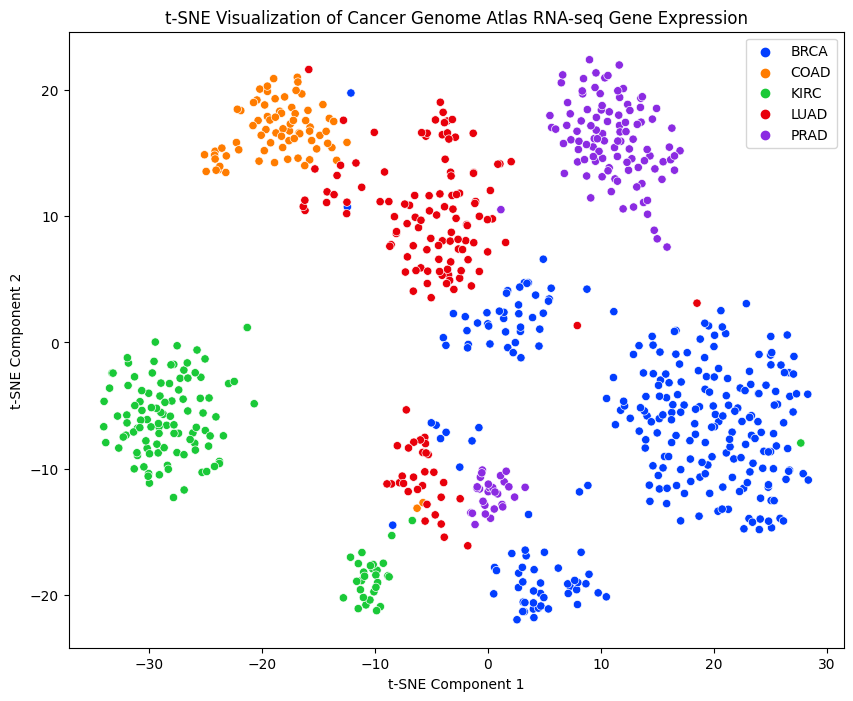

In [ ]:
# your code here
exp = pd.read_csv('/content/drive/MyDrive/QBS/five-cancers-gene-expression.csv')
exp.head()
# separate features and target variable
X = exp.iloc[:, 2:].values
y = exp.iloc[:, 1].values

# apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, legend='full', palette='bright')
plt.title('t-SNE Visualization of Cancer Genome Atlas RNA-seq Gene Expression')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

t-SNE is a probabilistic technnique and the goal is to minimize the distance between two distributions of the pairwise similarities. In the case above, it does a good job of that besides at the bottom of the plot. These are only the first two components, but there is clear separation in the genes. At the top right, there is a clear purple group, a clear blue group at the right, a clear green group on the left, and an orange and red group at the top. However, towards the middle, the colors mix and the separation is not as good. 

**(b)**

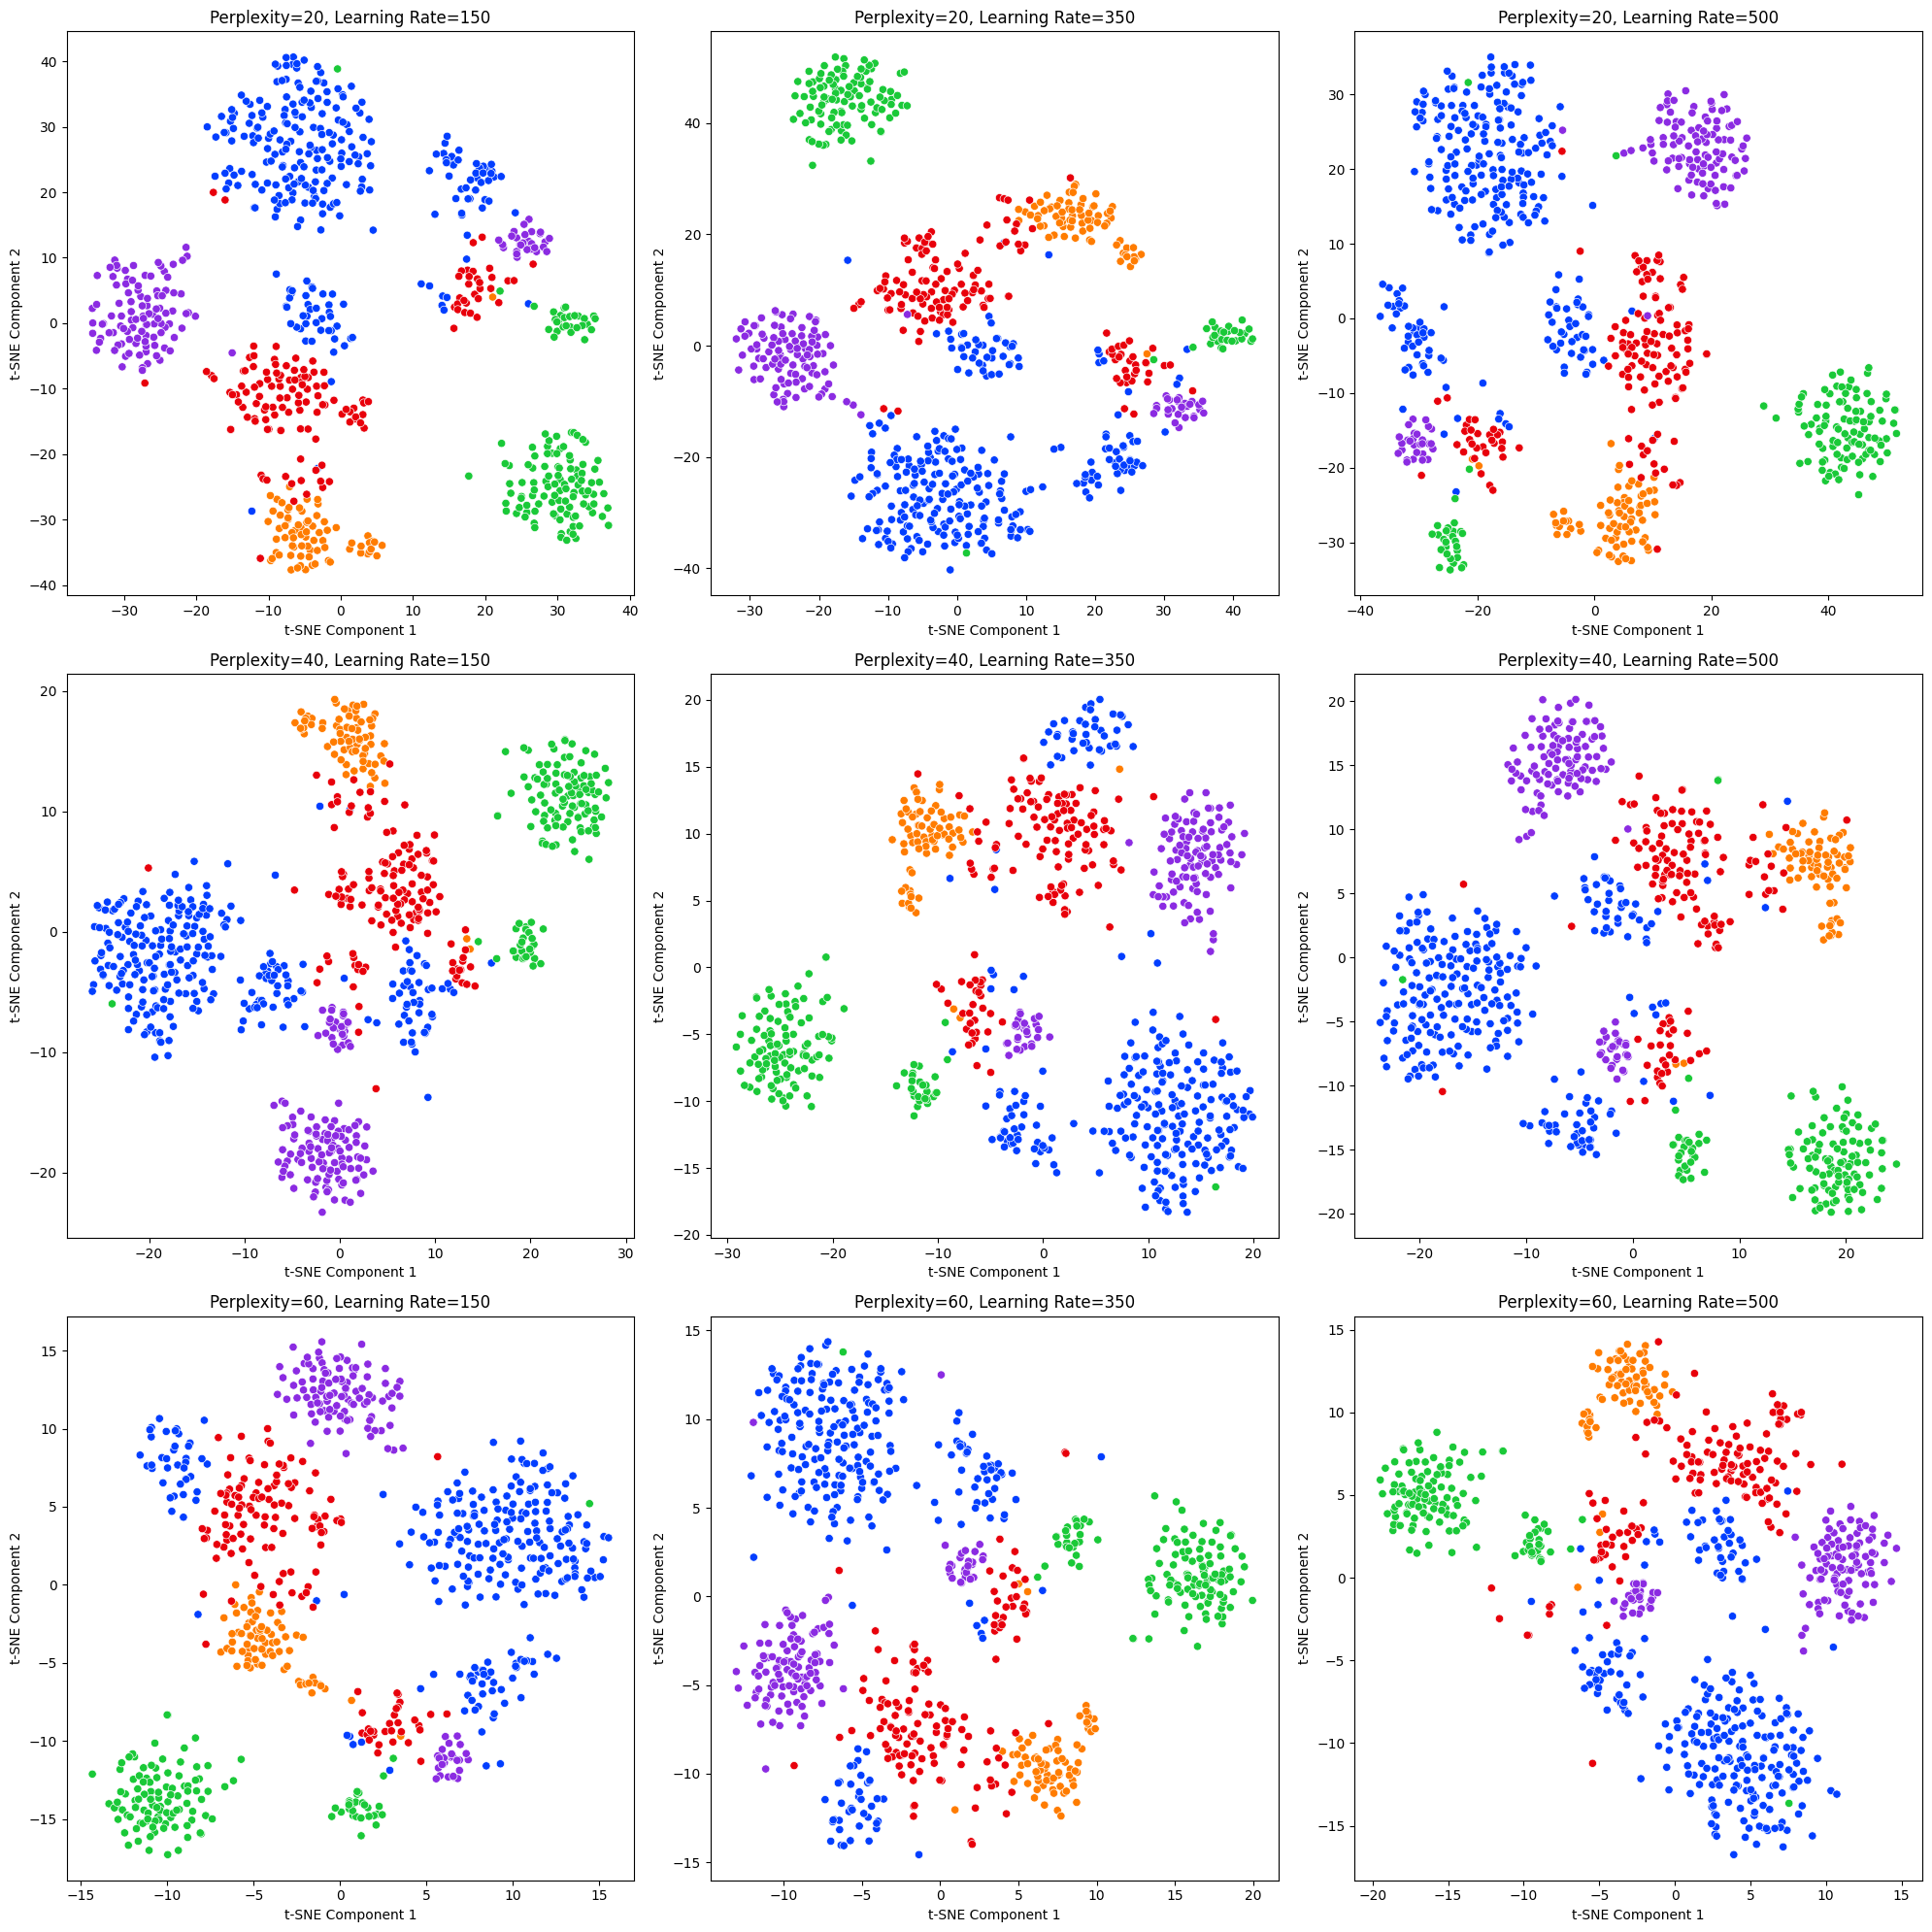

In [ ]:
# Your code here
# hyperparameter tuning
perplexities = [ 20, 40, 60]
learning_rates = [ 150,350, 500]
n_iter = 1000

fig, axes = plt.subplots(nrows=len(perplexities), ncols=len(learning_rates), figsize=(20, 20))
for i, perplexity in enumerate(perplexities):
    for j, learning_rate in enumerate(learning_rates):
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
        X_tsne = tsne.fit_transform(X)

        # plot the results
        ax = axes[i, j]
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, legend=False, palette='bright', ax=ax)
        ax.set_title(f'Perplexity={perplexity}, Learning Rate={learning_rate}')
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

* When changing the learning rate, the relative locations of points in the clusters do not change very much. However, in most cases, when the learning rate is changed, the clusters themselves tend to move around and rotate. As for changing the perplexity, the higher perplexities seem to seperate the correct genes marginally better. The clusters also rotate around when the perplexity is changed. If I were to select the best t-SNE parameters with this data, I would choose a perplexity of 60 and a learning rate of 500

## Question 3 CNN for Fish Species Classification
You might find some useful information at https://pytorch.org/vision/main/models.html and at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

In [2]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Replace 'None' with a transforms.Compose instance for image transformations.
# Define the transforms for the training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the transforms for the validation data
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms = {
    'train': train_transform,  
    'val': val_transform,
}

### 3.1 Model Training
#### 3.1.1 Tasks
**(a).You are asked to complete the fish species classification task in three ways. Initialize a Resnet18 model using ALL of the following three ways:**

1. Using the pre-trained Resnet18 model as a fixed feature extractor (only fine-tune the fully-connected layer);
2. Fine-tuning all layers of the pre-trained Resnet18 model;
3. Training a Resnet18 model from scratch.

In [7]:
# Replace 'None' with your dataset directory
train_dir = '/content/drive/MyDrive/QBS/Fish/train'
val_dir = '/content/drive/MyDrive/QBS/Fish/val'
test_dir = '/content/drive/MyDrive/QBS/Fish/test'

train_set = datasets.ImageFolder(train_dir,data_transforms['train'])
val_set = datasets.ImageFolder(val_dir, data_transforms['val'])
test_set = datasets.ImageFolder(test_dir, data_transforms['val'])

In [8]:
num_classes = len(train_set.classes)
assert num_classes==4

In [9]:
# TODO: Complete the following code
"""
1. Load a pre-trained ResNet-18 model as a model_extractor. (We have already done this for you)
2. Freeze all the layers of the model_extractor.
3. Replace the last fully connected layer (model_extractor.fc) with a new Linear layer that matches the number of classes.
4. Move the model to GPU if applicable.
"""
# Step 1: Load a pre-trained ResNet-18 model as a model_extractor
model_extractor = models.resnet18(pretrained=True)

# Step 2: Freeze all the layers of the model_extractor
for param in model_extractor.parameters():
    param.requires_grad = False

# Step 3: Replace the last fully connected layer with a new Linear layer that matches the number of classes
num_classes = 4  # Replace with the actual number of classes
model_extractor.fc = nn.Linear(model_extractor.fc.in_features, num_classes)

# Step 4: Move the model to GPU if applicable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_extractor.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# TODO: Complete the following code
"""
1. Load a pre-trained ResNet-18 model as a model_finetune.
2. Replace the last fully connected layer (model_finetune.fc) with a new Linear layer that matches the number of classes.
3. Move the model to GPU if applicable.
"""

# Your code starts here
import torch.nn as nn

# Load a pre-trained ResNet-18 model for fine-tuning
model_finetune = models.resnet18(pretrained=True)

# Replace the last fully connected layer with a new linear layer that matches the number of classes
num_classes = 4
model_finetune.fc = nn.Linear(model_finetune.fc.in_features, num_classes)

# Move the model to GPU if applicable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_finetune = model_finetune.to(device)

In [11]:
# TODO: Complete the following code
"""
1. Load a random initialized ResNet-18 model as model_scratch.
2. Replace the last fully connected layer (model_scratch.fc) with a new Linear layer that matches the number of classes.
3. Move the model to GPU if applicable.
"""

# Your code starts here
# Load a randomly initialized ResNet-18 model
model_scratch = models.resnet18(pretrained=False)

# Replace the last fully connected layer with a new linear layer that matches the number of classes
num_classes = 4
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, num_classes)

# Move the model to GPU if applicable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_scratch = model_scratch.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**(b).Before training, can you speculate how the training will be different between thesethree approaches? Which way do you think is the most appropriate given this fishing dataset,and why?**

Training the model with the pre-trained Resnet18 model only requires training of the last fully connected layer and is thus faster. The fine-tuned model has to go through all the layers but can adjust better to the data. The scratch model will likely take longest to converge and requires a lot of data. The fine-tuned model is likely the best because it can adjust all the layers while also being able to adjust the model more than the pre-trained model. 

#### 3.1.2 Model Training/Fine-tuning 

Explain the design of your workflow. Your workflow should include the following components:
* Appropriate data transformation and augmentation;
* Loss function and optimizer;
* Training policy, including the number of epochs, batch size, learning rate. 

**Explain your workflow here**:
The datasets were loaded in the forms of data loaders with two workers each. The transformations defined previously were applied to the training, validation, and test sets. The transformations for training and validation were different to ensure the results are generalizable. 

The cross entropy function was used because we are trying to predict if the image was classified correctly. The adam optimizer will be used.

A learning rate scheduler was used, and early stopping with a patience of 4 was used. The learning rate was set to 0.0001.


In [12]:
# Define data loaders for the training, validation, and test sets
batch_size = 32
#data loader uses the transformations set at the beginning of the problems.
#The transformations are different for the train and val/test
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Define a loss function
#want to put emphasis on positively identified images
criterion = nn.CrossEntropyLoss()

# Define an optimizer Adam used
learning_rate = 0.0001
optimizer = optim.Adam(model_extractor.parameters(), lr=learning_rate)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

In [13]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    # TODO: Complete this function based on the following instructions.

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    
        
    """
    1. Move the data and target tensors to the device (GPU preferable).
    2. Zero the gradients of the optimizer.
        3. Perform a forward pass through the model.
        4. Calculate the loss.
        5. Calculate the gradients.
        6. Update the model parameters using the optimizer.
        7. Add the loss for this batch to the running loss for the epoch.
    """

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss
        
    """
    1. You might want to print the loss every some iterations so you can monitor the training earlier.
    2. Calculate the epoch loss by dividing the running loss by the number of samples in the train_loader.
    3. Return the epoch loss.
    """
    # Your code here
    
    pass


In [14]:
def test(model, device,test_loader, criterion):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output, target)
          test_loss += loss.item() 
          
       # Calculate the number of correct predictions for this batch.
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
            
    # Calculate the average test loss and accuracy across all batches.
    # Return the average test loss.
    # Your code here
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(accuracy)
    return test_loss
            # TODO: Complete the following code
    """
            1. Move the data and target tensors to the device (GPU preferable).
            2. Perform a forward pass through the model to get the output.
            3. Calculate the test loss for this batch.
            4. Calculate the number of correct predictions for this batch.
            5. Accumulate the test loss and the number of correct predictions across all batches.
     """

            # Your code here
            
    # Calculate the average test loss and accuracy across all batches.
    # Return the average test loss.
    # Your code here
    
    pass

In [15]:
import copy
total_epoch = 20
train_losses_extractor = []
val_losses_extractor = [] 
best_loss_extractor = 10000
best_model_extractor = None #You don't need to replace 'None' this line
early_counter = 0
patience = 4
best_epoch_extractor = 0

for epoch in range(1, total_epoch + 1):
    print(epoch)
    # Train the model for one epoch and get the training loss
    train_loss = train(model_extractor, device, train_loader, optimizer, criterion) # Replace '...'
    train_losses_extractor.append(train_loss)
    
    # Validate the model on the validation set and get the validation loss
    val_loss = test(model_extractor, device, val_loader, criterion)
    val_losses_extractor.append(val_loss)
    print(val_loss)
    if val_loss < best_loss_extractor:
      best_loss_extractor = val_loss
      best_model_extractor = copy.deepcopy(model_extractor)
      early_stop = 0
      best_epoch_extractor = epoch
    else: 
      early_stop +=1
    
    if early_stop >= patience:
      print("Early stopped")
      break


    # TODO: Complete the following code
    """
    1. Check if the current validation loss is lower than the best validation loss.
    2. If it is, update the best validation loss with the current validation loss.
    3. Also, update the best model parameters with the current model parameters.
    """

    # Your code here

    if scheduler is not None:
        scheduler.step(val_loss)



1
39.6551724137931
0.044422907562091433
2
41.810344827586206
0.042916126292327356
3
46.98275862068966
0.04125529065214355
4
50.43103448275862
0.03979615327613107
5
52.58620689655172
0.0390334658581635
6
55.172413793103445
0.03788282259784896
7
56.03448275862069
0.03696674211271878
8
56.03448275862069
0.03612299546085555
9
56.89655172413793
0.035604853054572796
10
57.758620689655174
0.03498843903171605
11
56.89655172413793
0.034145908365989554
12
58.189655172413794
0.03373572076189107
13
59.48275862068966
0.033394733379627096
14
60.775862068965516
0.03286260880272964
15
60.775862068965516
0.03280273054180474
16
62.06896551724138
0.032501708844612384
17
61.206896551724135
0.031939066175756786
18
62.06896551724138
0.03158363263154852
19
62.06896551724138
0.03132224237096721
20
62.5
0.031015674358811873


In [16]:
optimizer = optim.Adam(model_finetune.parameters(), lr=learning_rate)
early_stop = 0
patience = 4
# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

total_epoch = 20
train_losses_fine = []
val_losses_fine = [] 
best_loss_fine = 10000
best_model_fine = None #You don't need to replace 'None' this line
best_epoch_fine = 0


for epoch in range(1, total_epoch + 1):
    print(epoch)
    # Train the model for one epoch and get the training loss
    train_loss = train(model_finetune, device, train_loader, optimizer, criterion) # Replace '...'
    train_losses_fine.append(train_loss)
    
    # Validate the model on the validation set and get the validation loss
    val_loss = test(model_finetune, device, val_loader, criterion)
    val_losses_fine.append(val_loss)
    print(val_loss)
    if val_loss < best_loss_fine:
      best_loss_fine = val_loss
      best_model_fine = copy.deepcopy(model_finetune)
      early_stop = 0
      best_epoch_fine = epoch
    else: 
      early_stop +=1
    
    if early_stop >= patience:
      print("Early stopped")
      break

    # TODO: Complete the following code
    """
    1. Check if the current validation loss is lower than the best validation loss.
    2. If it is, update the best validation loss with the current validation loss.
    3. Also, update the best model parameters with the current model parameters.
    """

    # Your code here

    if scheduler is not None:
        scheduler.step(val_loss)

1
79.3103448275862
0.019720423581271337
2
83.62068965517241
0.0153032712124545
3
86.20689655172414
0.01319197918577441
4
87.93103448275862
0.011173415463417768
5
88.79310344827586
0.011541179284967226
6
88.79310344827586
0.01104614802571977
7
88.36206896551724
0.011685421987404597
8
89.65517241379311
0.012729927977739737
9
90.94827586206897
0.011406260783430832
10
89.22413793103448
0.010765530666786021
11
92.24137931034483
0.010499294718791699
12
90.51724137931035
0.011511521253349453
13
88.79310344827586
0.011889705150428325
14
91.8103448275862
0.011513752746144872
15
87.06896551724138
0.015225583727567875
Early stopped


In [17]:
total_epoch = 20
train_losses_scratch = []
val_losses_scratch = [] 
best_loss_scratch = 10000
best_model_scratch = None #You don't need to replace 'None' this line
early_stop = 0
patience = 4
optimizer = optim.Adam(model_scratch.parameters(), lr=learning_rate)
best_epoch_scratch = 0
# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


for epoch in range(1, total_epoch + 1):
    print(epoch)
    # Train the model for one epoch and get the training loss
    train_loss = train(model_scratch, device, train_loader, optimizer, criterion) # Replace '...'
    train_losses_scratch.append(train_loss)
    
    # Validate the model on the validation set and get the validation loss
    val_loss = test(model_scratch, device, val_loader, criterion)
    val_losses_scratch.append(val_loss)
    print(val_loss)
    if val_loss < best_loss_scratch:
      best_loss_scratch = val_loss
      best_model_scratch = copy.deepcopy(model_scratch)
      early_stop = 0
      best_epoch_scratch = 0
    else: 
      early_stop +=1
    
    if early_stop >= patience:
      print("Early stopped")
      break
      

    # TODO: Complete the following code
    """
    1. Check if the current validation loss is lower than the best validation loss.
    2. If it is, update the best validation loss with the current validation loss.
    3. Also, update the best model parameters with the current model parameters.
    """

    # Your code here

    if scheduler is not None:
        scheduler.step(val_loss)

1
47.8448275862069
0.03691211985103015
2
58.189655172413794
0.033153423718337356
3
54.741379310344826
0.03494600360763484
4
56.46551724137931
0.03163519809985983
5
60.775862068965516
0.031112268952460123
6
52.58620689655172
0.03601392994410005
7
60.3448275862069
0.0335158610652233
8
62.06896551724138
0.0301187863123828
9
63.793103448275865
0.02746348031635942
10
63.36206896551724
0.029093665937925207
11
68.10344827586206
0.0252522688744397
12
74.13793103448276
0.02398232113698433
13
69.82758620689656
0.02482956108348123
14
58.189655172413794
0.034353516867448544
15
70.25862068965517
0.02513603339421338
16
76.72413793103448
0.02222613258094623
17
77.58620689655173
0.021093006149448198
18
72.84482758620689
0.024522908674231892
19
71.55172413793103
0.024208553263853336
20
70.25862068965517
0.024643926335306002


### 3.2 Results
**(a) Generate a plot of training and validation loss curves for each of the three trainingcases. On the plots, mark the epoch that you selected as the best model,and explain your choice.**

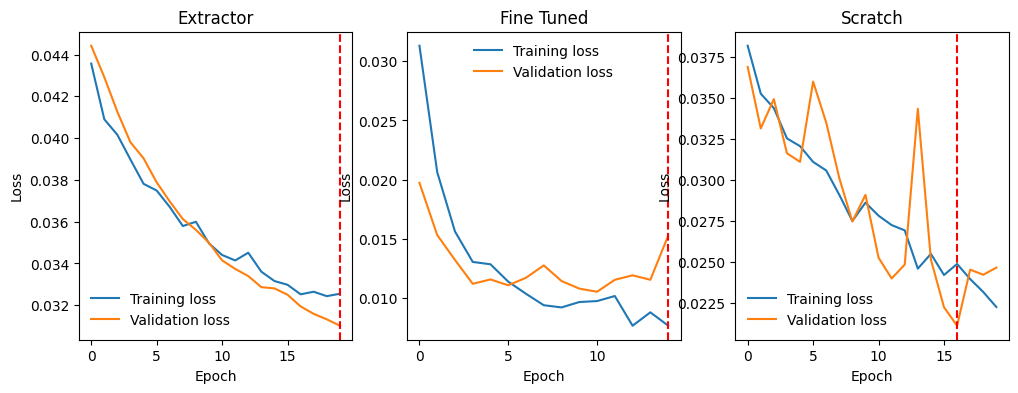

In [19]:
# Your code here
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Plot the training and validation loss curves
axs[0].plot(train_losses_extractor, label='Training loss')
axs[0].plot(val_losses_extractor, label='Validation loss')
axs[0].legend(frameon=False)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Extractor')
axs[0].axvline(x=19, color='red', linestyle='--')

axs[1].plot(train_losses_fine, label='Training loss')
axs[1].plot(val_losses_fine, label='Validation loss')
axs[1].legend(frameon=False)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Fine Tuned')
axs[1].axvline(x=14, color='red', linestyle='--')

axs[2].plot(train_losses_scratch, label='Training loss')
axs[2].plot(val_losses_scratch, label='Validation loss')
axs[2].legend(frameon=False)
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].set_title('Scratch')
axs[2].axvline(x=16, color='red', linestyle='--')
plt.show()

**(b) Choose a single best performing model as your final model, and report the confusion matrix, per-class accuracy, and weighted F1 score of this model on the validation set.**

To evaluate your model on the evaluation set, first use your best model to obtain predictions for the evaluation set.

In [25]:
val_loss = test(best_model_fine, device, val_loader, criterion) #prints accuracy

print(val_loss)

true_label = []
pred_label = []
with torch.no_grad():
  for data, target in val_loader:
    data, target = data.to(device), target.to(device)
    output = best_model_fine(data)
    _,pred = torch.max(output, dim=1)
    true_label += target.cpu().numpy().tolist()
    pred_label += pred.cpu().numpy().tolist()

92.24137931034483
0.010499294718791699


Then, show the performance of your best model on the evaluation set. You may find the scikit-learn library useful for this task, which provides several metrics for model evaluation. You can find more information on model evaluation metrics in scikit-learn here: https://scikit-learn.org/stable/modules/model_evaluation.html

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
# Ensure true_label and pred_label are of the same data type
true_label = np.array(true_label)
pred_label = np.array(pred_label)

conf_mat = confusion_matrix(true_label, pred_label)
per_class_acc = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
weighted_f1_score = f1_score(true_label, pred_label, average='weighted')

print('Confusion Matrix:\n', conf_mat)
print('Per-class Accuracy:\n', per_class_acc)
print('Weighted F1 Score:', weighted_f1_score)


Confusion Matrix:
 [[76  4  2  1]
 [ 5 41  0  0]
 [ 3  0 27  0]
 [ 2  0  1 70]]
Per-class Accuracy:
 [0.91566265 0.89130435 0.9        0.95890411]
Weighted F1 Score: 0.9227312898566213


### 3.3 Model Performance Evaluation
Use your best performing model to predict the image labels for the held-out test set. Save your predictions in **`<YourNetID>`_CNN_predictions.csv** with the image filename (‘XXX.JPG’) in the first column, and your prediction (“ALB”, “YFT”, “OTHER”, OR “NoF”) in the second column.Please see Example_CNN_predictions.csv for the correct format.

In [30]:
# Your code here
import pandas as pd
test_preds = []

for data,_ in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = best_model_fine(data)
        _, pred = torch.max(output, dim=1)
        test_preds.extend(pred.cpu().numpy().tolist())

test_preds = np.array(test_preds).flatten()  # flatten the list of predictions
filenames = [test_set.samples[i][0].split('/')[-1] for i in range(len(test_set))]
df = pd.DataFrame({'filename': filenames, 'label': test_preds})
df['label'] = df['label'].apply(lambda x: train_set.classes[x])
df.to_csv('/content/drive/MyDrive/QBS/f006mjr_CNN_predictions.csv', index=False, header=None)

## Question 4 Generating Fake Images like Real
Your task is to generate images using Generative Adversarial Networks (GANs) based on the well-known MNIST dataset. The MNIST dataset consists of handwritten digits from 0 to 9 and is widely used in image classification applications. You may find some useful information in this PyTorch tutorial on DCGANs for generating images: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. 

Please ensure you have access to a GPU for running this part of the project, as using a CPU may result in excessively long computation times. You can take advantage of the free GPU resources available on Google Colab.

In [31]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load MNIST data
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_dataset = datasets.MNIST(root="./mnist_data", download=True, train=True, transform=transform)

# Replace 'None' with the appropriate values.
batch_size = 128
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 102342227.65it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45539734.52it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25750508.79it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6562359.20it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### 4.1 Design GAN's architecture

**(a) Design a Generator network to generate fake images.**

In [32]:
image_size = 32

In [33]:
# Define inputs, same as from blog
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128


# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64


# Learning rate for optimizers
lr = 0.0007

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [34]:
#Initializing weights function
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [35]:
class Generator(nn.Module):
    def __init__(self, nz=nz, ngf=ngf, nc=nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
          # input is Z, going into a convolution
          nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf * 8),
          nn.ReLU(True),
          # state size. ``(ngf*8) x 4 x 4``
          nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 4),
          nn.ReLU(True),
          # state size. ``(ngf*4) x 8 x 8``
          nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf * 2),
          nn.ReLU(True),
          # state size. ``(ngf*2) x 16 x 16``
          nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
          #nn.BatchNorm2d(ngf),
          #nn.ReLU(True),
          # state size. ``(ngf) x 32 x 32``
          #nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
          
      )
    def forward(self, input):
      input = input.to(device)
      return self.main(input)


**(b) Design a Discriminator network to distinguish real and fake images.**

In [36]:
class Discriminator(nn.Module):
    def __init__(self, ngpu = ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
           
            nn.Conv2d(nc, ndf, 2, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
           
            nn.Conv2d(ndf, ndf * 2, 2, 2,1 , bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
      input = input.to(device)
      return self.main(input)

### 4.2 Model Training

**(a) Initializing the networks, optimizers, and loss function.**

In [37]:
# Replace 'None' with the appropriate values.
generator = Generator().to(device)
#generator.apply(weights_init)
discriminator = Discriminator().to(device)
#discriminator.apply(weights_init)
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()
noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [38]:
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

**(b) Alternatively training the Discriminator and Generator.**



We have provided a portion of the starter code below to assist you in completing this task more easily. Please complete the provided code and ensure that it runs successfully.

In [60]:
import torchvision.utils as vutils
def train(train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion):
    torch.cuda.set_device(device)
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    num_epochs = 15
    print("Starting Training Loop...")
    

    # For each epoch
    for epoch in range(num_epochs):
      for i, (real_image,_) in enumerate(train_loader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            optimizer_D.zero_grad()
            # Format batch
            real_cpu = real_image.to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            
            # Forward pass real batch through D
            output = discriminator(real_cpu).view(-1)
            # Calculate loss on all-real batch
            label = label.view(-1)
            errD_real = criterion(output, label.expand_as(output))
            # Calculate gradients for D i
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label.expand_as(output))
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizer_D.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            optimizer_G.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label.expand_as(output))
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizer_G.step()

            # Output training stats
            if i % 100 == 0:
              print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{i}/{len(train_loader)}], Discriminator Loss: {errD_real:.4f}, Generator Loss: {errG:.4f}')

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
              with torch.no_grad():
                fake = generator(noise).detach().cpu()
              img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters+=1
    return G_losses, D_losses, img_list

**(c) Plotting and saving the loss of both the Generator and Discriminator during training.**

In [61]:
# Your code here

gen_results = train(data_loader, generator, discriminator, optimizer_G, optimizer_D, criterion)

Starting Training Loop...
Epoch [1/15], Iteration [0/469], Discriminator Loss: 0.0042, Generator Loss: 4.6723
Epoch [1/15], Iteration [100/469], Discriminator Loss: 0.0546, Generator Loss: 3.3908
Epoch [1/15], Iteration [200/469], Discriminator Loss: 0.0451, Generator Loss: 3.3477
Epoch [1/15], Iteration [300/469], Discriminator Loss: 0.1588, Generator Loss: 3.6469
Epoch [1/15], Iteration [400/469], Discriminator Loss: 0.0223, Generator Loss: 4.7262
Epoch [2/15], Iteration [0/469], Discriminator Loss: 0.0034, Generator Loss: 5.7775
Epoch [2/15], Iteration [100/469], Discriminator Loss: 0.0029, Generator Loss: 6.7175
Epoch [2/15], Iteration [200/469], Discriminator Loss: 0.0687, Generator Loss: 2.9849
Epoch [2/15], Iteration [300/469], Discriminator Loss: 6.1331, Generator Loss: 1.6853
Epoch [2/15], Iteration [400/469], Discriminator Loss: 0.0085, Generator Loss: 5.1673
Epoch [3/15], Iteration [0/469], Discriminator Loss: 0.0017, Generator Loss: 5.2996
Epoch [3/15], Iteration [100/469],

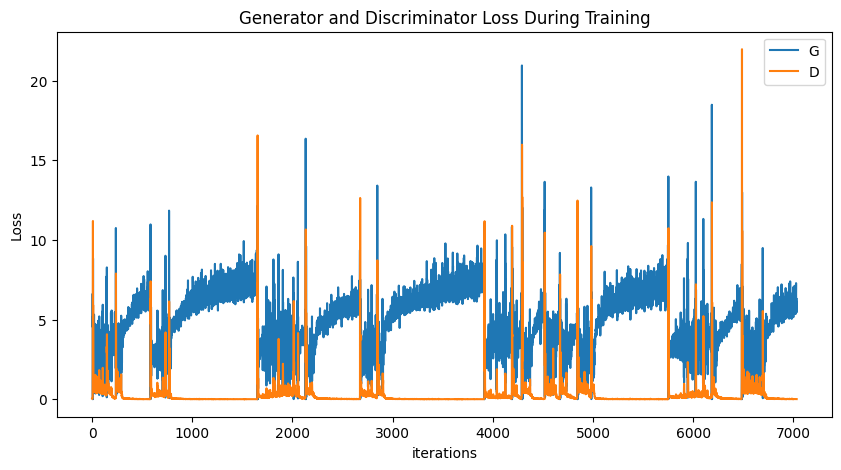

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_results[0],label="G")
plt.plot(gen_results[1],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 4.3 Evaluation

In [65]:
#Save and upload the generator model you trained. 
student_id = 'f006mjr'
torch.save(generator, f"/content/drive/MyDrive/QBS/f006mjr_GAN.pt")

If you want to visualize your generated images, you can use the following code:

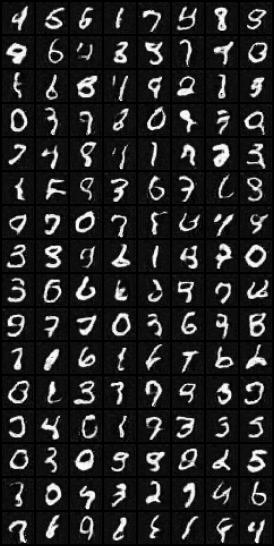

In [67]:
from torchvision.utils import save_image
from IPython.display import Image
#Typically, you will need random noise vectors to generate fake images. The generator you trained
#learns to map noise vectors to real images during the training process.
generated_images = generator(noise)
save_image(generated_images, "/content/drive/MyDrive/QBS/generated_samples.png",normalize=True)
Image(filename="/content/drive/MyDrive/QBS/generated_samples.png")